In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import zoom

from scipy.ndimage.filters import gaussian_filter as gf

from hyss_util import *

In [48]:
# -- matplotlib defaults
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gist_gray"

In [3]:
# -- load both 2013 and 2018 scan
imgL_hsi0_half0 = np.load("../output/filtered_hsi0_half0.npy")
imgL_hsi0_half1 = np.load("../output/filtered_hsi0_half1.npy")
hsi0 = np.hstack([imgL_hsi0_half0, imgL_hsi0_half1])

# imgL_hsi1_half0 = np.load("../output/filtered_hsi1_half0.npy")
# imgL_hsi1_half1 = np.load("../output/filtered_hsi1_half1.npy")
# hsi1 = np.hstack([imgL_hsi1_half0, imgL_hsi1_half1])

In [4]:
# -- get mean brightness images and save them if necessary
fnameL0 = "../output/hsi0_filter_mean.npy"
fnameL1 = "../output/hsi1_filter_mean.npy"

if os.path.isfile(fnameL0):
    imgL_hsi0 =  np.load(fnameL0)
else:
    print("{0} not found!  creating and writing...".format(fnameL0))
    imgL_hsi0 = hsi0.mean(axis=0)
    np.save(fnameL0, imgL_hsi0)

if os.path.isfile(fnameL1):
    imgL_hsi1 =  np.load(fnameL1)
else:
    print("{0} not found!  creating and writing...".format(fnameL1))
    imgL_hsi1 = hsi1.mean(axis=0)
    np.save(fnameL1, imgL_hsi1)

In [5]:
# -- get the overlapping area
img_L1_rs = zoom(imgL_hsi1, np.divide((695, 1252), (1600, 3195)), order = 1)
img_L1 = img_L1_rs[:, 165:1252]
img_L0 = imgL_hsi0[238:933, 0:1087]
nrow, ncol = img_L0.shape

In [7]:
imgL_hsi1.shape

(1600, 3195)

In [8]:
img_L1_rs.shape

(695, 1252)

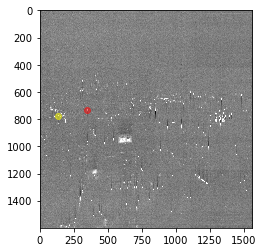

In [6]:
plt.imshow(imgL_hsi0, clim=[-3, 3])
plt.scatter(346, 238+494, c = "red", alpha = 0.5)
plt.scatter(132, 238+540, c = "yellow", alpha = 0.5)

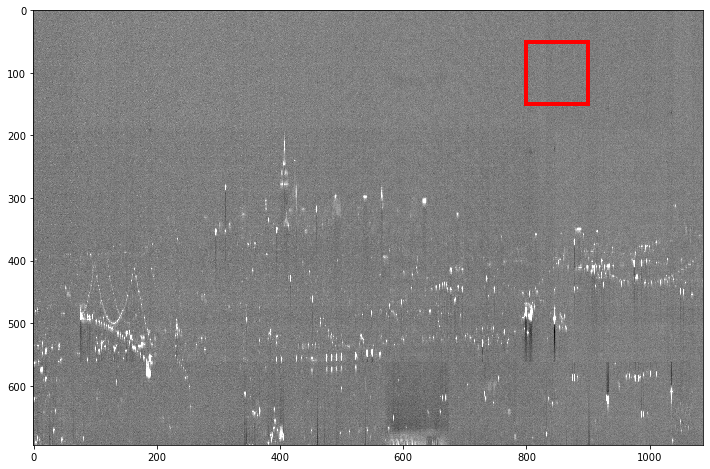

In [7]:
# -- plot luminosity
fig, ax = plt.subplots(figsize = (12, 8))
ax.imshow(img_L0, interpolation="nearest", aspect="auto", clim=[-3, 3])
rect = patches.Rectangle((800, 50), 100, 100, linewidth=4, edgecolor='red', facecolor='none')
ax.add_patch(rect)

In [9]:
# -- defining the region for calculating linear scaling model
pat_rr = [420, 465]
pat_cc = [150, 200]

patch_L1 = img_L1[pat_rr[0]:pat_rr[1], pat_cc[0]:pat_cc[1]]
patch_L0 = img_L0[pat_rr[0]:pat_rr[1], pat_cc[0]:pat_cc[1]]


# -- calculate the slope and offset for sensor sensitivity correction (clip to remove outliers)
clp = (-5, 5)
slp, off = np.polyfit(patch_L1.flatten().clip(-5, 5), patch_L0.flatten().clip(clp[0], clp[1]), 1)


# -- create a noise realization for HSI1
#    (amplitude roughly determined by clipping values to < 1 and comparing std dev)
np.random.seed(302)
sig = 0.21
noise = np.random.randn(nrow, ncol) * sig

# -- create scaled image and final, noisy image
img_L1_scl = img_L1 * slp + off
img_L1_fnl = img_L1_scl + noise

In [10]:
img_L0.shape

(695, 1087)

In [10]:
np.save("../output/img_L1_fnl_zoom.npy", img_L1_fnl)

In [15]:
np.save("../output/img_L0_overlap.npy", img_L0)

In [13]:
img_L1_fnl = np.load("../output/img_L1_fnl_zoom.npy")
img_L1_fnl

array([[ 0.2269446 ,  0.0309422 ,  0.34706752, ...,  0.18468003,
         0.15271947, -0.04412678],
       [-0.07745529, -0.01195155,  0.19803368, ...,  0.13879794,
        -0.05291749,  0.16507791],
       [-0.08421028,  0.01231404,  0.17456526, ..., -0.16742501,
        -0.09343793,  0.25268462],
       ...,
       [ 0.18680226, -0.09195272, -0.37885959, ..., -0.26507822,
         0.04775958, -0.09904847],
       [ 0.34834136,  0.03089736, -0.10942545, ..., -0.03017712,
        -0.37718084, -0.4975533 ],
       [-0.1356398 ,  0.26222371, -0.16159649, ..., -0.31585672,
        -0.14739351,  0.1985795 ]])

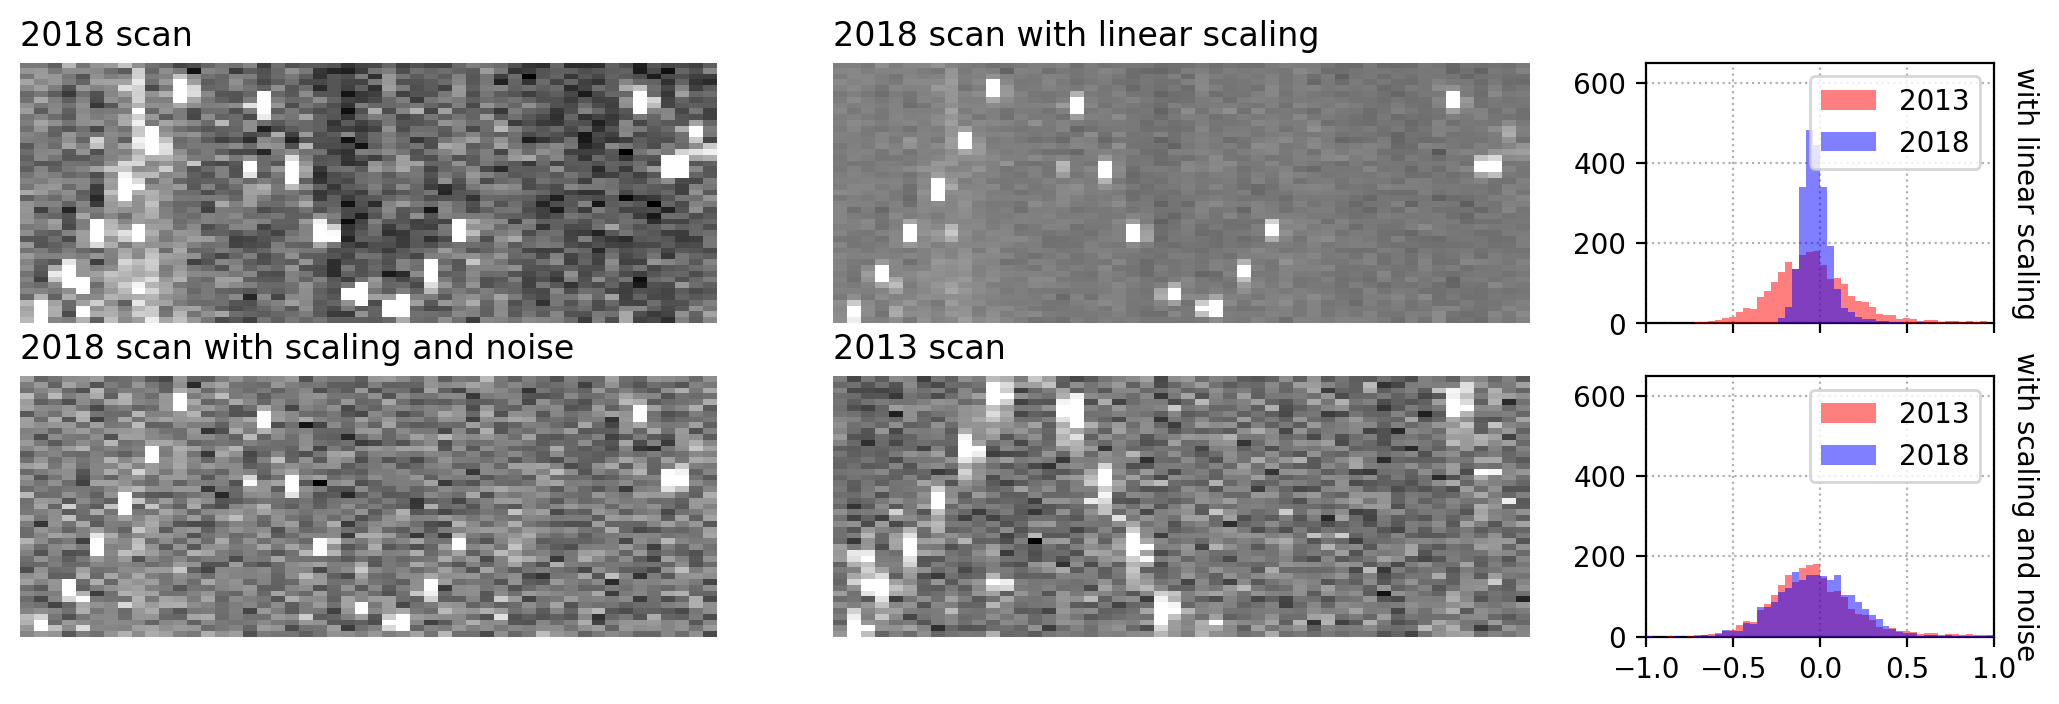

In [11]:
# -- make a 4-panel plot showing original HSI1, scaled HSI1, final HSI1, and HSI0
fig, ax = plt.subplots(2, 3, figsize=(10.5, 3.5), gridspec_kw={"width_ratios": [2, 2, 1]}, dpi=200)
fig.subplots_adjust(0.03, 0.09, 0.97, 0.91)

# -- define patches
patch_L1_scl = img_L1_scl[pat_rr[0]:pat_rr[1], pat_cc[0]:pat_cc[1]]
patch_L1_fnl = img_L1_fnl[pat_rr[0]:pat_rr[1], pat_cc[0]:pat_cc[1]]

# -- set up labels
labs_im = ["2018 scan", "2018 scan with linear scaling", "2018 scan with scaling and noise", "2013 scan"]
labs_hs = ["with linear scaling", "with scaling and noise"]

# -- plot patches
for ii, timg in enumerate([patch_L1, patch_L1_scl, patch_L1_fnl, patch_L0]):
    ir = ii // 2
    ic = ii % 2
    ax[ir, ic].imshow(timg, aspect="auto", clim=[-1, 1])
    ax[ir, ic].set_title(labs_im[ii], loc="left")
    ax[ir, ic].axis("off")


# -- add histograms

for ii, timgs in enumerate(((patch_L0, patch_L1_scl), (patch_L0, patch_L1_fnl))):
    ax[ii, 2].hist(timgs[0].flatten(), bins=50, range=[-1, 1], alpha=0.5, color="red", zorder=3)
    ax[ii, 2].hist(timgs[1].flatten(), bins=50, range=[-1, 1], alpha=0.5, color="blue", zorder=3)
    ax[ii, 2].set_xlim(-1, 1)
    ax[ii, 2].set_ylim(0, 650)
    ax[ii, 2].grid(True, ls=":", zorder=0)
    ax[ii, 2].text(1.1, 325, labs_hs[ii], va="center", rotation=-90)
    ax[ii, 2].legend(["2013", "2018"])

    if ii == 0:
        ax[ii, 2].set_xticklabels("")


# -- show figure
fig.show()

# -- save figure
# fig.savefig("../output/scaling_noise_alignment.png")

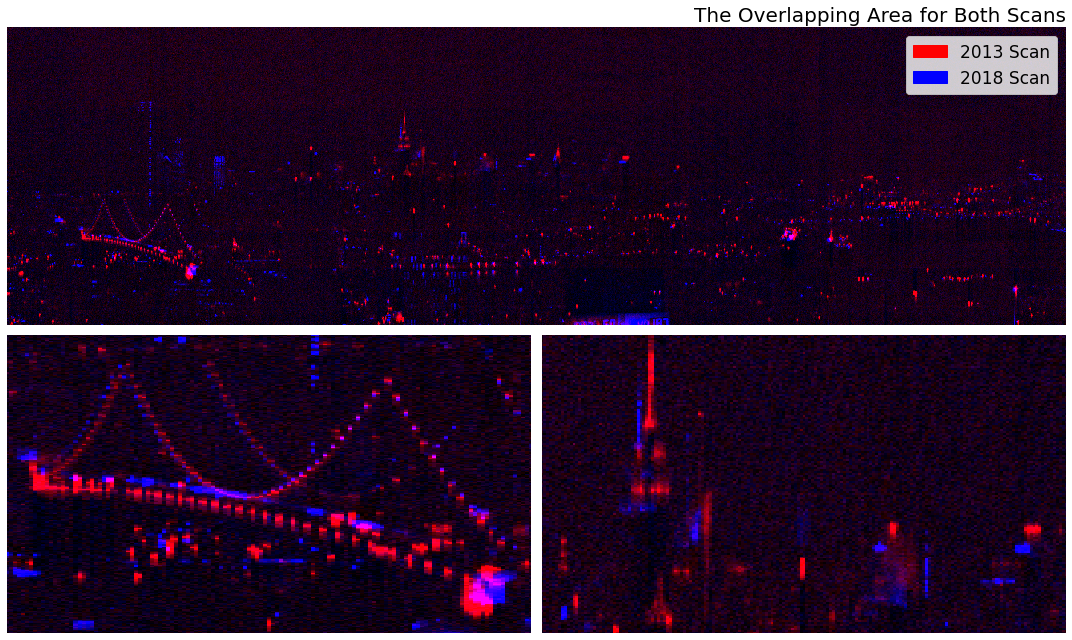

In [13]:
# -- create a 3-channel image

# -- make a 3-channel image
red = (img_L0.clip(-5, 5) + 5) / 10
blu = (img_L1_fnl.clip(-5, 5) + 5) / 10
rgb = np.dstack((red, np.zeros_like(red), blu))

rgb = (3*rgb - 1.4).clip(0, 1)


fig, ax = plt.subplots(figsize=(15, 9))

ax1 = plt.subplot(2,1,1)
ax1.imshow(rgb, interpolation="nearest", aspect="auto")
ax1.set_title("The Overlapping Area for Both Scans", loc='right', fontsize=20)
ax2 = plt.subplot(2,2,3)
ax3 = plt.subplot(2,2,4)
ax2.imshow(rgb, interpolation="nearest", aspect="auto")
ax3.imshow(rgb, interpolation="nearest", aspect="auto")
# ax[2].imshow(rgb, interpolation="nearest", aspect="auto")
ax2.set_ylim(600, 380)
ax2.set_xlim(70, 200)
ax3.set_ylim(350, 200)
ax3.set_xlim(370, 550)

axes = [ax1, ax2, ax3]
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
# fig.legend()# add legend, upper right 
# fig.tight_layout()

df_legend = pd.DataFrame([
                          [0, [255, 0, 0], '2013 Scan'],
                            [1, [0, 0, 255], '2018 Scan'],
    
                          ],
                         columns=['key', 'color', 'name'])

handles_1 = [patches.Rectangle((0, 0), 1, 1, color=[c / 255 for c in color_list]) for color_list in df_legend['color']]
labels = df_legend['name']

ax1.legend(handles_1, labels, loc='upper right', ncol=1, fontsize=17)

fig.tight_layout()

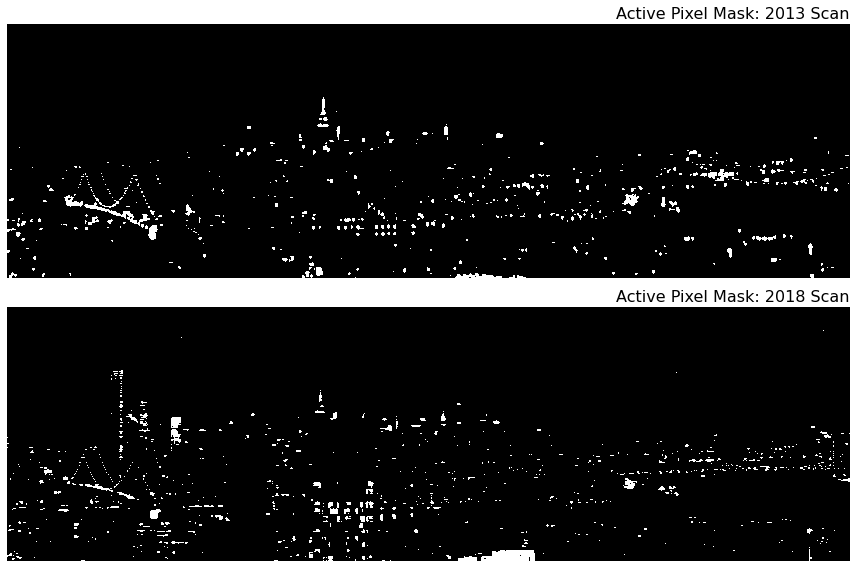

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 8))


ax[0].imshow(gf(1.0 * (img_L0 > 0.7), 1) > 0.25, cmap="gist_gray", aspect="auto")
ax[0].set_title("Active Pixel Mask: 2013 Scan", loc='right', fontsize=16)

ax[1].imshow(gf(1.0 * (img_L1_fnl > 0.7), 1) > 0.25, cmap="gist_gray", aspect="auto")
ax[1].set_title("Active Pixel Mask: 2018 Scan", loc='right', fontsize=16)
ax[0].axis('off')
ax[1].axis('off')
fig.tight_layout()
# ax.set_ylim(465, 420)
# ax.set_xlim(150, 200)

In [14]:
# # -- make a 3-channel image (this is after sensor sensitivity correction)
# red1 = (img_L0.clip(-5, 5) + 5) / 10
# blu1 = (img_L1_fnl.clip(-5, 5) + 5) / 10

# rgb = np.dstack((red, np.zeros_like(red), blu))
# rgb1 = np.dstack((red1, np.zeros_like(red1), blu1))

# rgb = np.dstack((red, np.zeros_like(red), blu))
# rgb1 = np.dstack((red1, np.zeros_like(red1), blu1))

# fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (15, 8), gridspec_kw={'width_ratios': [2, 1]})


# ax[0, 0].imshow(rgb, interpolation="nearest", aspect="auto")
# ax[1, 0].imshow(rgb1, interpolation="nearest", aspect="auto")
# ax[0, 0].axis('off')
# ax[1, 0].axis('off')

# ax[0, 0].set_ylim(465, 420)
# ax[0, 0].set_xlim(150, 200)

# ax[1, 0].set_ylim(465, 420)
# ax[1, 0].set_xlim(150, 200)


# ax[0, 1].hist(patch_L0_2.flatten(), bins=50, range = (-1, 1), color = "red")
# ax[0, 1].hist(img_L1[420:465, 150:200].flatten(), bins=50,  range = (-1, 1), alpha=0.5, color = "blue");
# ax[0, 1].grid(color = 'grey', linestyle = '--', linewidth = 0.5)

# ax[1, 1].hist(patch_L0_2.flatten(), bins=50,  range = (-1, 1), color = "red")
# ax[1, 1].hist(patch_i3_2.flatten(), bins=50, alpha=0.5,range = (-1, 1),  color = "blue");
# ax[1, 1].grid(color = 'grey', linestyle = '--', linewidth = 0.5)
# fig.text(0.663, 0.97, 'Intensity Distribution Before Correction', va='center', fontsize = 18)
# fig.text(0.663, 0.50, 'Intensity Distribution After Correction', va='center', fontsize = 18)
# fig.subplots_adjust(hspace=8)


# ax[0, 1].legend(['2013 Scan', '2018 Scan'], fontsize=17)
# ax[1, 1].legend(['2013 Scan', '2018 Scan'], fontsize=17)
# ax[0, 1].set_yticks(np.arange(0, 400, 100))
# ax[1, 1].set_yticks(np.arange(0, 400, 100))
# ax[0, 1].set_xticks(np.arange(-1, 1, 0.25))
# ax[1, 1].set_xticks(np.arange(-1, 1, 0.25))
# ax[1, 1].set_xlabel("Pixel's Intensity", fontsize=19)

# df_legend = pd.DataFrame([
#                           [0, [255, 0, 0], '2013 Scan'],
#                             [1, [0, 0, 255], '2018 Scan'],
    
#                           ],
#                          columns=['key', 'color', 'name'])

# handles_1 = [patches.Rectangle((0, 0), 1, 1, color=[c / 255 for c in color_list]) for color_list in df_legend['color']]
# labels = df_legend['name']

# ax[0, 0].legend(handles_1, labels, loc='upper right', ncol=1, fontsize=17,)

# fig.tight_layout()

In [24]:
# -- get active source location and spec for both 2013 and 2018 hyperspectral scan
# -- if raw file exists, read it, create file if not
dname = "../output/hsi0_overlap_cnn_allwave_bridg.npy" 

if os.path.isfile(dname):

  print("Active source file for the 2013 scan is existed")

else:
  dpath0 = os.path.join(os.environ["LTCO_HSI0"], "full frame 20ms faster_VNIR.raw")
  # -- read 2013 scan and then get raw spectra data for these sources
  cube = read_hyper(dpath0)

  # -- manually set threshold and apply gf
  imgL0_gf = gf(1.0 * (img_L0 > 0.7), 1) > 0.25
  imgL0_overlap = 1.0 * np.array(imgL0_gf)

  # -- get raw spec data for 'active' pixel
  img_data = cube.data

  spec = []
  for i in range(len(img_data)):
    spec.append(img_data[i][238:933, 0:1087][imgL0_gf])

  spec = np.vstack(spec)
  np.save("../output/hsi0_overlap_cnn_allwave_bridge.npy", spec)


  # -- get location for 'active' pixel and  save it
  hsi0_indices = np.argwhere(imgL0_overlap == 1)
  hsi0_indices


  np.save("../output/hsi0_overlap_location_bridge.npy", hsi0_indices)


reading and parsing full frame 20ms faster_VNIR.hdr...
reading full frame 20ms faster_VNIR.raw...


In [22]:
hsi0_indices.shape

(15075, 2)

In [26]:
# -- if raw file exists, read it, create file if not
dname = "../output/hsi1_overlap_cnn_allwave_bridge.npy" 

if os.path.isfile(dname):

  print("Active source file for the 2018 scan is existed")

else: 
 
  # -- read 2018 scan and then get raw spectra data for these sources
  dpath = os.path.join(os.environ["LTCO_HSI1"], "night_00000.raw")
  cube = read_hyper(dpath)

  # -- manually set threshold and apply gf
  imgL1_gf = gf(1.0 * (img_L1_fnl > 0.7), 1) > 0.25
  imgL1_overlap = 1.0 * np.array(imgL1_gf)

  # -- get raw spec data for 'active' pixel
  img_data = cube.data

  spec = []
  for i in range(len(img_data)):
    spec.append((zoom(img_data[i], np.divide((695, 1252), (1600, 3195)), order = 1)[:, 165:1252])[imgL1_gf])

  spec = np.vstack(spec)
  np.save("../output/hsi1_overlap_cnn_allwave_bridge.npy", spec)


  # -- get location for 'active' pixel and then save it
  hsi1_indices = np.argwhere(imgL1_overlap == 1)

  np.save("../output/hsi1_overlap_location_bridge.npy", hsi1_indices)

reading and parsing night_00000.hdr...
reading night_00000.raw...


In [7]:
spec = np.load("../output/hsi0_overlap_cnn_allwave_bridge.npy")
spec.shape

(872, 15075)

In [8]:
spec = np.load("../output/hsi1_overlap_cnn_allwave_bridge.npy")
spec.shape

(848, 15453)

Text(1.0, 1.0, 'Unknown Spectra in 2013 Scan')

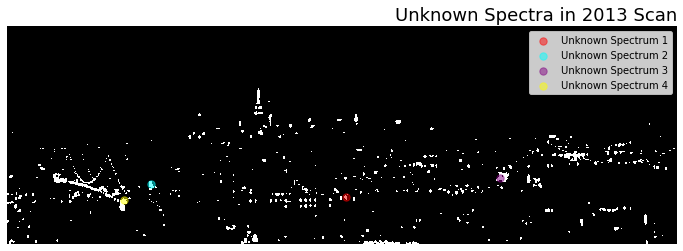

In [50]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.imshow(gf(1.0 * (img_L0 > 0.7), 1) > 0.25, cmap="gist_gray", aspect="auto")
ax.scatter(549, 546,   c = "red", alpha = 0.5, marker='o',  s=54,label = "Unknown Spectrum 1")
ax.scatter(233,  502, c = "cyan", alpha = 0.5, marker='o',  s=54,label = "Unknown Spectrum 2")
ax.scatter(799,  485, c = "purple", alpha = 0.5,marker='o', s=54, label = "Unknown Spectrum 3")
ax.scatter(189,  554, c = "yellow", alpha = 0.5, marker='o', s=54,label = "Unknown Spectrum 4")
ax.legend()
ax.axis('off')
ax.set_title("Unknown Spectra in 2013 Scan", loc = "right", fontsize = 18)



In [6]:
# -- load waves range for both scans
waves0 = np.load("../output/graham_hall_upload/cube0_waves_range.npy")
waves1 = np.load("../output/graham_hall_upload/cube1_waves_range.npy")

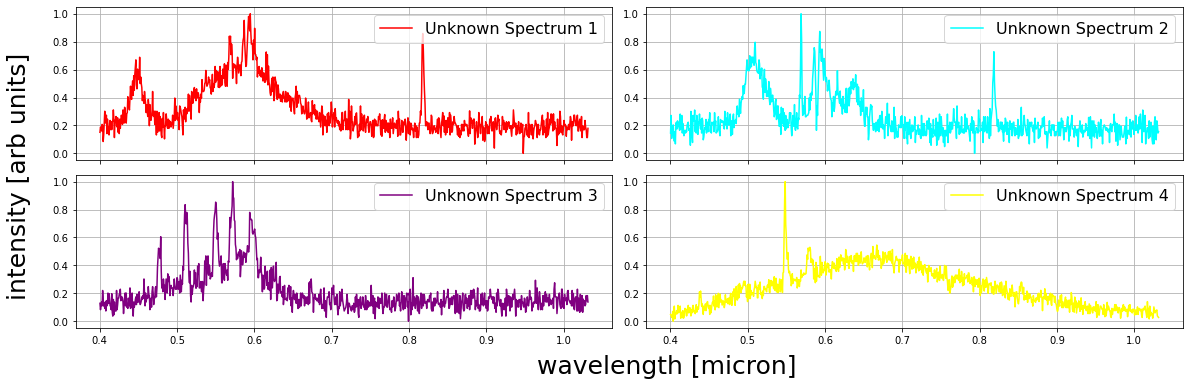

In [63]:
def norm_data(spec):
    norm = (spec - spec.min()) / (spec.max() - spec.min())
    return norm


fig, ax = plt.subplots(2, 2,figsize=(16, 5))
ax[0, 0].plot(waves0/1000, norm_data(hsi0[:, 238+546, 549]),   c = "red",label = "Unknown Spectrum 1")
ax[0, 1].plot(waves0/1000, norm_data(hsi0[:, 238+502, 233]), c = "cyan", label = "Unknown Spectrum 2")
ax[1, 0].plot(waves0/1000, norm_data(hsi0[:, 238+485, 799]), c = "purple",  label = "Unknown Spectrum 3")
ax[1, 1].plot(waves0/1000, norm_data(hsi0[:, 238+554, 189]), c = "yellow",label = "Unknown Spectrum 4")

ax[0, 0].legend(fontsize=16)
ax[0, 1].legend(fontsize=16)
ax[1, 0].legend(fontsize=16)
ax[1, 1].legend(fontsize=16)

ax[0, 0].set_xticklabels([])
ax[0, 1].set_xticklabels([])
ax[0, 0].grid(":", axis="x")
ax[0, 1].grid(":", axis="x")
ax[1, 0].grid(":", axis="x")
ax[1, 1].grid(":", axis="x")

ax[0, 0].grid(":", axis="y")
ax[0, 1].grid(":", axis="y")
ax[1, 0].grid(":", axis="y")
ax[1, 1].grid(":", axis="y")

fig.text(-0.03, 0.5, 'intensity [arb units]', va='center', rotation='vertical', fontsize = 25)
fig.text(0.43, -0.03, 'wavelength [micron]', va='center', fontsize = 25)
fig.tight_layout()

In [42]:
img_L1_rs = zoom(imgL_hsi1, np.divide((695, 1252), (1600, 3195)), order = 1)
img_L1 = img_L1_rs[:, 165:1252]

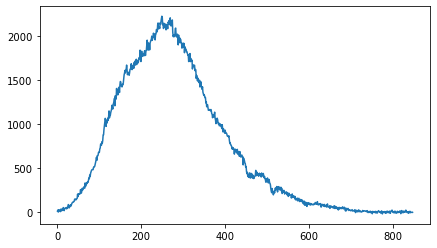

In [16]:
plt.plot(hsi1[:, 1125, 686])
plt.plot(hsi1[:, 676, 1232])

NameError: name 'img_L1_fnl' is not defined

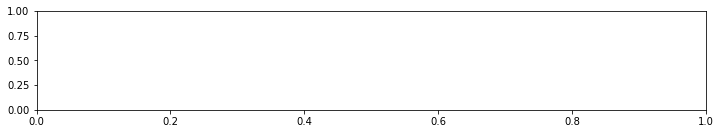

In [45]:
fig, ax = plt.subplots(figsize=(12, 4))

ax1 = plt.subplot(2,1,1)
ax1.imshow(gf(1.0 * (img_L1_fnl > 0.7), 1) > 0.25, cmap="gist_gray", aspect="auto")
ax1.scatter(104, 489,   c = "red", alpha = 0.5)
ax1.scatter(318,  294, c = "cyan", alpha = 0.5)
ax2 = plt.subplot(2,2,3)
ax3 = plt.subplot(2,2,4)
ax2.plot(waves1, hsi1[:, 1125, 686], c = "red")
ax3.plot(waves1, hsi1[:, 676, 1232], c = "cyan")
fig.tight_layout()

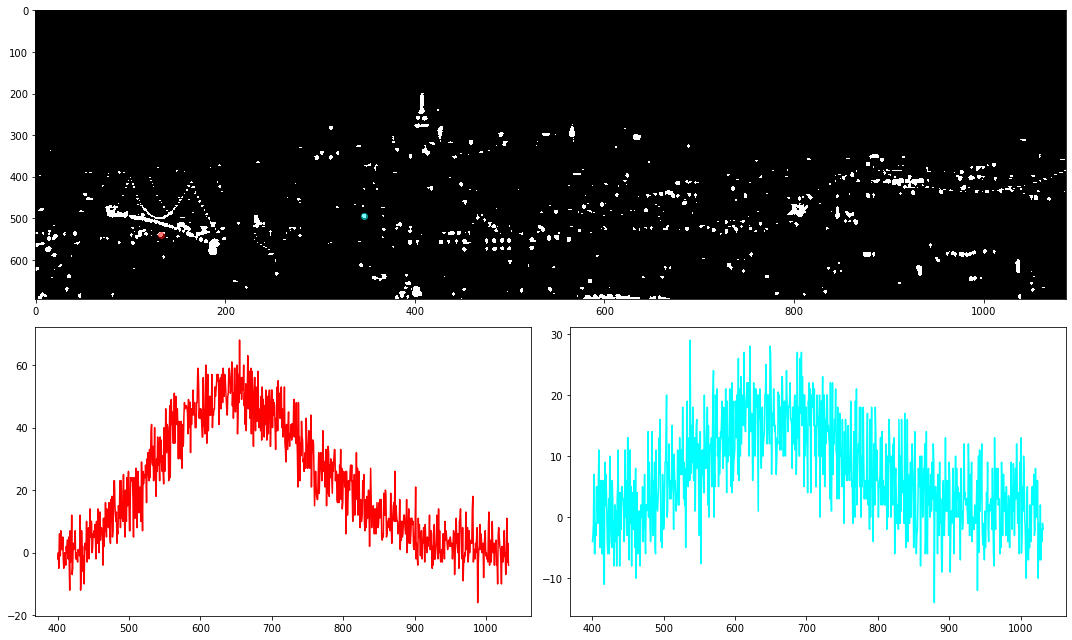

In [15]:
fig, ax = plt.subplots(figsize=(15, 9))

ax1 = plt.subplot(2,1,1)
ax1.imshow(gf(1.0 * (img_L0 > 0.7), 1) > 0.25, cmap="gist_gray", aspect="auto")
ax1.scatter(132, 540,   c = "red", alpha = 0.5)
ax1.scatter(346,  494, c = "cyan", alpha = 0.5)
ax2 = plt.subplot(2,2,3)
ax3 = plt.subplot(2,2,4)
ax2.plot(waves0, hsi0[:, 238+540, 132], c = "red")
ax3.plot(waves0, hsi0[:, 238+494, 346], c = "cyan")
fig.tight_layout()

Text(1.0, 1.0, 'Active Pixel Mask: 2013 Scan')

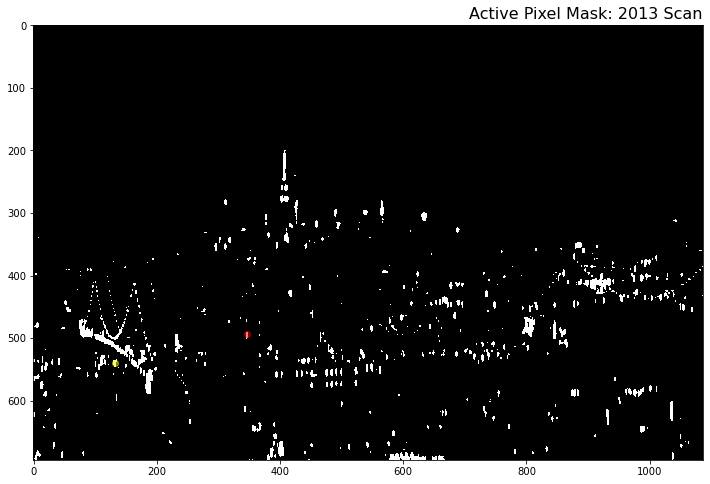

In [29]:
plt.subplots(figsize = (12, 8))


plt.imshow(gf(1.0 * (img_L0 > 0.7), 1) > 0.25, cmap="gist_gray", aspect="auto")
plt.scatter( 346,494, c = "red", alpha = 0.5)
plt.scatter( 132, 540,c = "yellow", alpha = 0.5)
plt.title("Active Pixel Mask: 2013 Scan", loc='right', fontsize=16)